In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function, division

import numpy as np

plot_to_pdf = True

if plot_to_pdf:
    import matplotlib as mpl
    mpl.use('pdf')
    
    import matplotlib.pyplot as plt
    
    plt.rc('font', family='serif', serif='Times')
    plt.rc('text', usetex=True)
    plt.rc('xtick', labelsize=8) # 10
    plt.rc('ytick', labelsize=8) # 10
    plt.rc('axes', labelsize=8) # 10
    plt.rc('legend', fontsize=8) # 10
    title_font_size = 8
    data_font_size = 8
else:
    import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d

import time

from copy import deepcopy

from topological_memory_clustering.homology import *
from topological_memory_clustering.quadrotor import plot_state_trajectories_3d, plot_control
from topological_memory_clustering.clustering import *

%matplotlib inline

In [3]:
data = np.load('202101_datasets/quadrotor_dataset_maze_random_start_points_10k.npz')
print(list(data.keys()))

samples_X = data['samples_X'][:,:,:]
samples_U = data['samples_U']
samples_final_cost = data['samples_final_cost']
print(samples_X.shape, samples_U.shape, samples_final_cost.shape)

KeysView(<numpy.lib.npyio.NpzFile object at 0x7f69103867f0>)
(9243, 12, 50) (9243, 49, 4) (9243,)


# Cost histogram

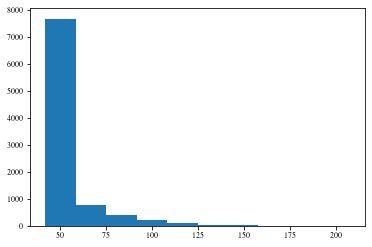

In [4]:
plt.hist(samples_final_cost)
plt.show()

In [5]:
# Only include with cost < 18
threshold = 75. #30. #18.08 #18.05
samples_X = samples_X[samples_final_cost < threshold]
samples_U = samples_U[samples_final_cost < threshold]
samples_final_cost = samples_final_cost[samples_final_cost < threshold]
print(samples_X.shape, samples_U.shape, samples_final_cost.shape)

# Full dataset
samples_X_full = samples_X.copy()
samples_U_full = samples_U.copy()
samples_final_cost_full = samples_final_cost.copy()

(8454, 12, 50) (8454, 49, 4) (8454,)


In [6]:
sample_downsampling_factor = 40
# sample_downsampling_factor = 5
time_downsampling_factor = 2

# Downsample number of samples
samples_X = samples_X[::sample_downsampling_factor, :, :]
samples_U = samples_U[::sample_downsampling_factor, :, :]
samples_final_cost = samples_final_cost[::sample_downsampling_factor]

# Store original samples before downsampling time (for prettier plotting later)
samples_X_original = samples_X.copy()
samples_U_original = samples_U.copy()
samples_final_cost_original = samples_final_cost.copy()
print("Original", samples_X_original.shape, samples_U_original.shape, samples_final_cost_original.shape)

# Downsample time
samples_X = samples_X[:, :, ::time_downsampling_factor]
samples_U = samples_U[:, ::time_downsampling_factor, :]

print(samples_X.shape, samples_U.shape, samples_final_cost.shape)

Original (212, 12, 50) (212, 49, 4) (212,)
(212, 12, 25) (212, 25, 4) (212,)


In [7]:
sample_dim = samples_X.shape[0]
state_dim = samples_X.shape[1]
time_dim = samples_X.shape[2]
print(sample_dim, state_dim, time_dim)

212 12 25


# Plot raw trajectory samples

(212, 3, 50)


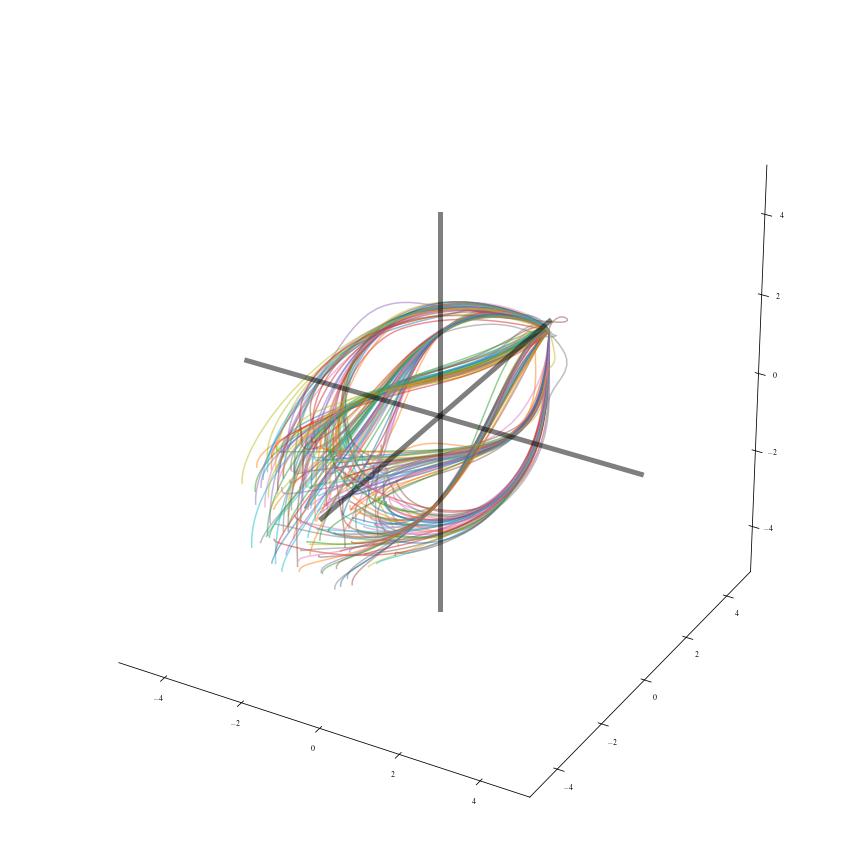

In [8]:
fig = plot_state_trajectories_3d(samples_X_original[:,:3,:])
plt.tight_layout()
plt.show()

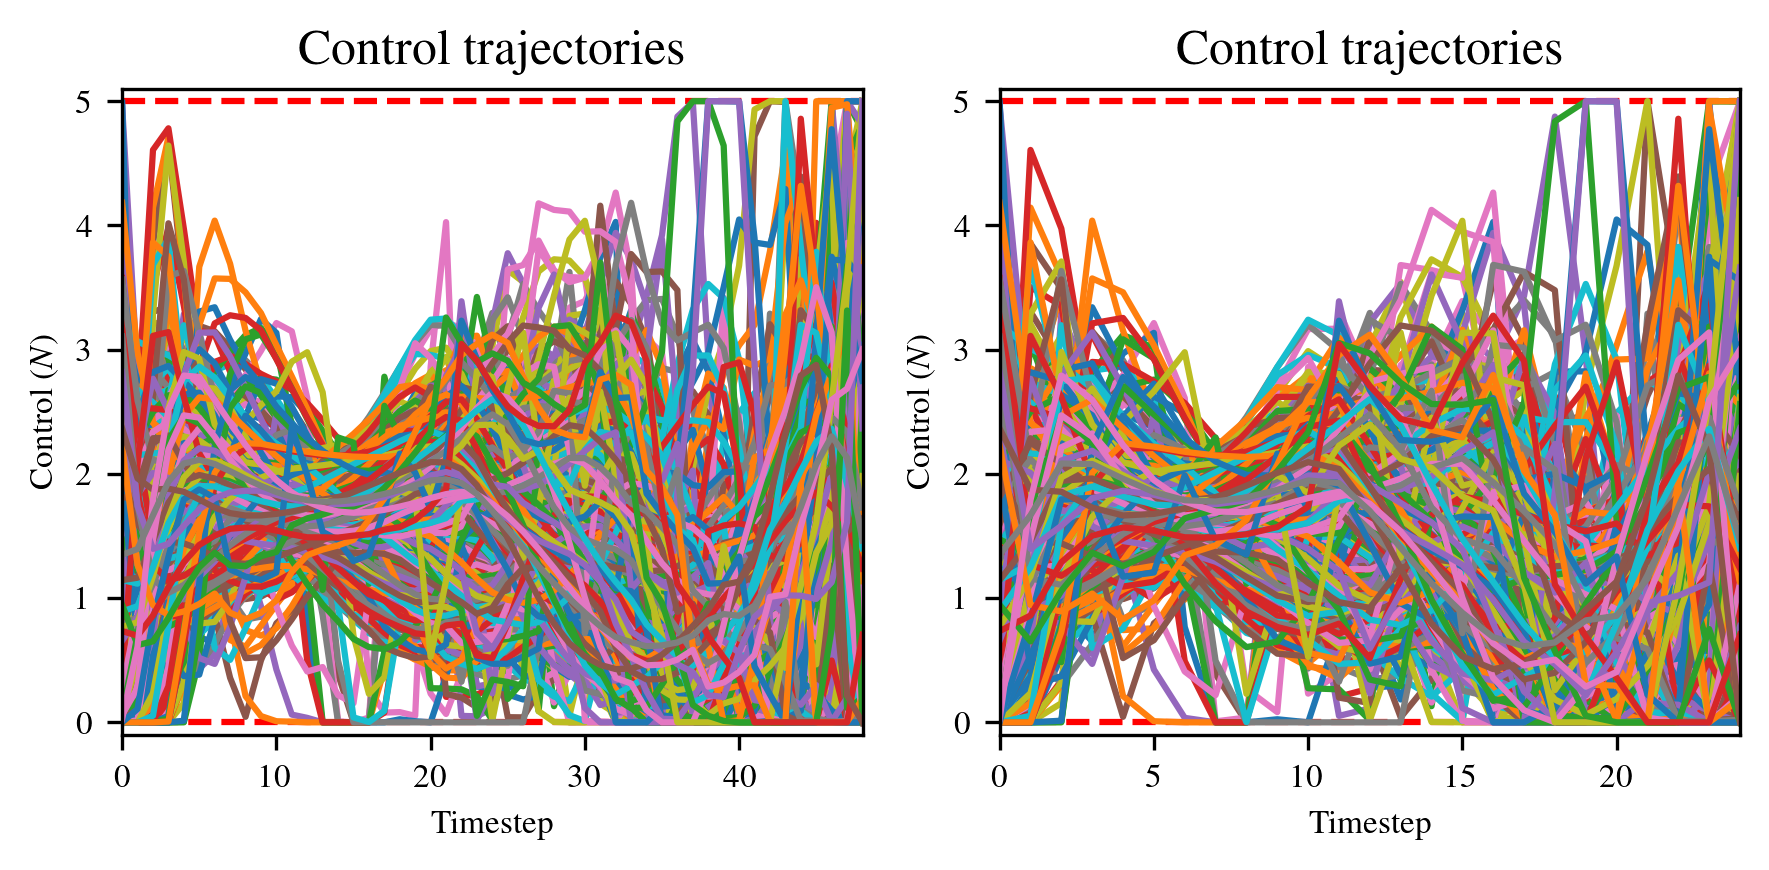

In [9]:
fig, ax = plt.subplots(1,2)
fig.set_dpi(300)
fig.set_size_inches(6,3)
plt.subplot(121)
plot_control(samples_U_original)
plt.hlines(0, 0, samples_U_original.shape[0], 'r', '--')
plt.hlines(5, 0, samples_U_original.shape[0], 'r', '--')
plt.ylim(-0.1,5.1)
plt.subplot(122)
plot_control(samples_U)
plt.hlines(0, 0, samples_U_original.shape[0], 'r', '--')
plt.hlines(5, 0, samples_U_original.shape[0], 'r', '--')
plt.ylim(-0.1,5.1)
plt.tight_layout()
plt.show()

# Run persistent homology

In [10]:
print(samples_X.shape)
demos = samples_X.swapaxes(1,2)
demos_full = samples_X_full[:,:,:].swapaxes(1,2)
print(demos.shape, demos_full.shape)

(212, 12, 25)
(212, 25, 12) (8454, 50, 12)


In [11]:
small_truncation_distance = None

## 3D filtration (xyz)
#### Run the filtration to identify _the number of clusters_ with a subset of data

Distance computation time: 2.104945421218872
Trajectory distance modification time: 0.0006232261657714844
[Dense] Elapsed Time: 3.65e+03 seconds, 9590976 Edges added
Potential number of holes: 1931
#classes 	 ratio 	 prev. 	 current 	 0.5*prev
       2	0.9866	2.4263	2.3937	1.9410
       3	0.8943	2.3937	2.1407	1.9150
       4	0.9930	2.1407	2.1257	1.7126
       5	0.9928	2.1257	2.1104	1.7006
       6	0.2320	2.1104	0.4896	1.6883
Identified 6 classes/clusters in data


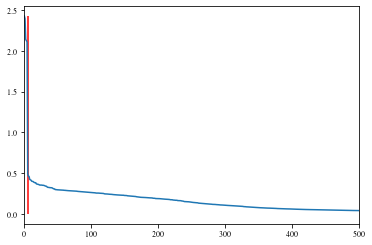

In [12]:
# Select 3d
demos_3d = demos[:,:,:3].copy()
dataset_3d = np.vstack([d for d in demos_3d])
result_3d, D_3d = compute_homology_filtration(demos_3d, dataset_3d, truncate_small_distances=small_truncation_distance, truncate_below_percentage=None, debug=True)

num_classes_3d, fig = get_num_classes_from_h1(result_3d['dgms'][1], debug=True)
print("Identified {0:d} classes/clusters in data".format(num_classes_3d))

plt.xlim(0,500)
plt.show()

### Run the pairwise comparison on the full dataset to assign labels (note: this is slow!)

In [13]:
demos_3d_full = demos_full[::1,::time_downsampling_factor,:3].copy()
s = time.time()
D_3d_trajectories = get_pairwise_trajectory_distance_matrix_simple(demos_3d_full)
e = time.time()
print("Pairwise distance computation took", e-s)

# Get labels based on pairwise distance matrix and number of classes
s = time.time()
labels_3d = get_cluster_labels_from_pairwise_trajectory_distance_matrix(num_classes_3d, D_3d_trajectories)
e = time.time()
print("Clustering took", e-s)

# Get colors for the clusters (for visualization)
colors_3d = get_colors_from_labels(labels_3d)

Pairwise distance computation took 7733.845848083496
Clustering took 1.3417799472808838


In [14]:
# Get labels based on pairwise distance matrix and number of classes
s = time.time()
labels_3d = get_cluster_labels_from_pairwise_trajectory_distance_matrix(num_classes_3d, D_3d_trajectories)
e = time.time()
print("Clustering took", e-s)

# Get colors for the clusters (for visualization)
colors_3d = get_colors_from_labels(labels_3d)

Clustering took 1.172797441482544


In [15]:
labels_unique = np.unique(labels_3d)
for u in labels_unique:
    print("Label {0} = {1}".format(u, np.count_nonzero(labels_3d==u)))

Label 0 = 1592
Label 1 = 1109
Label 2 = 2002
Label 3 = 1392
Label 4 = 1181
Label 5 = 1178


In [16]:
D_3d_trajectories.min(), D_3d_trajectories.max()

(0.0, 5.230175332130568)

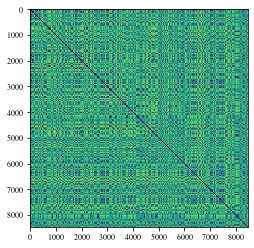

In [17]:
plt.imshow(D_3d_trajectories)
plt.show()

#### Visualize with cluster labels

(8454, 3, 25)


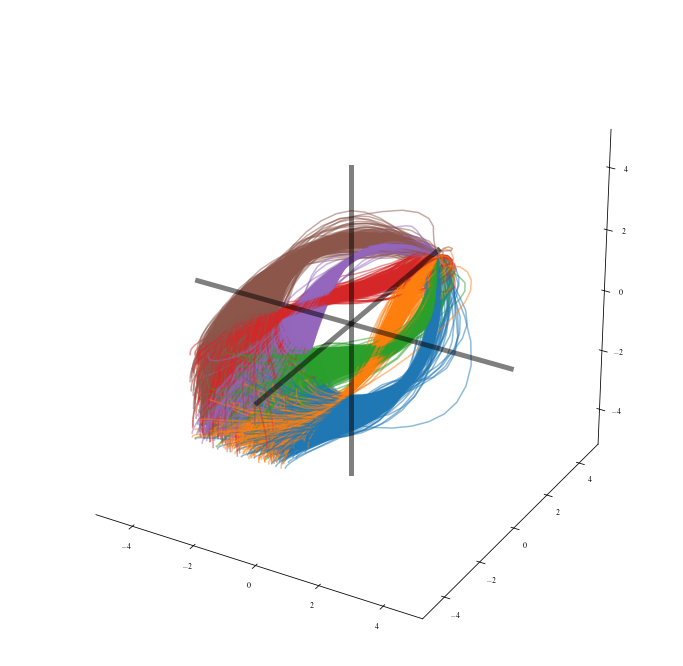

In [18]:
samples_to_plot = demos_3d_full[:,:,:3].copy()
samples_to_plot = np.swapaxes(samples_to_plot, 1, 2)
fig = plot_state_trajectories_3d(samples_to_plot, colors_3d)
plt.show()

## 6D filtration (xyz, rpy)

In [ ]:
demos_6d = demos[:,:,:6].copy()
dataset_6d = np.vstack([d for d in demos_6d])
result_6d, D_6d = compute_homology_filtration(demos_6d, dataset_6d, truncate_small_distances=small_truncation_distance, debug=True)

num_classes_6d = get_num_classes_from_h1(result_6d['dgms'][1], debug=False)[0]
print("Identified {0:d} classes/clusters in data".format(num_classes_6d))

In [ ]:
# D_6d_trajectories = get_pairwise_trajectory_distance_matrix(demos_6d, dataset_6d)

# labels_6d = get_cluster_labels_from_pairwise_trajectory_distance_matrix(num_classes_6d, D_6d_trajectories)
# colors_6d = get_colors_from_labels(labels_6d)
# print(num_classes_6d)

### Run the pairwise comparison on the full dataset to assign labels (note: this is slow!)

In [ ]:
# demos_6d_full = demos_full[:,:,:6].copy()
# dataset_6d_full = np.vstack([d for d in demos_6d_full])
# D_6d_trajectories = get_pairwise_trajectory_distance_matrix(demos_6d_full, dataset_6d_full, debug=True)

# # Get labels based on pairwise distance matrix and number of classes
# labels_6d = get_cluster_labels_from_pairwise_trajectory_distance_matrix(num_classes_6d, D_6d_trajectories)

# # Get colors for the clusters (for visualization)
# colors_6d = get_colors_from_labels(labels_6d)

In [ ]:
demos_6d_full = demos_full[:,::time_downsampling_factor,:6].copy()
D_6d_trajectories = get_pairwise_trajectory_distance_matrix_simple(demos_6d_full)

# Get labels based on pairwise distance matrix and number of classes
labels_6d = get_cluster_labels_from_pairwise_trajectory_distance_matrix(num_classes_6d, D_6d_trajectories)

# Get colors for the clusters (for visualization)
colors_6d = get_colors_from_labels(labels_6d)

In [ ]:
labels_unique = np.unique(labels_6d)
for u in labels_unique:
    print("Label {0} = {1}".format(u, np.count_nonzero(labels_6d==u)))

In [ ]:
plt.imshow(D_6d_trajectories)

In [ ]:
samples_to_plot = demos_6d_full[:,:,:3].copy()
samples_to_plot = np.swapaxes(samples_to_plot, 1, 2)
fig = plot_state_trajectories_3d(samples_to_plot, colors_6d)

## 12D filtration (xyz, rpy + velocities)

In [ ]:
demos_12d = demos[:,:,:12].copy()
# Scale down velocity component
velocity_scaling_factor = 1/5.
demos_12d[:,:,6:] *= velocity_scaling_factor
dataset_12d = np.vstack([d for d in demos_12d])
result_12d, D_12d = compute_homology_filtration(demos_12d, dataset_12d, truncate_small_distances=small_truncation_distance, debug=True)

num_classes_12d = get_num_classes_from_h1(result_12d['dgms'][1], debug=True)[0]
print("Identified {0:d} classes/clusters in data".format(num_classes_12d))

In [ ]:
demos_12d_full = demos_full[:,::time_downsampling_factor,:12].copy()
demos_12d_full[:,:,6:] *= velocity_scaling_factor
D_12d_trajectories = get_pairwise_trajectory_distance_matrix_simple(demos_12d_full)
# D_12d_trajectories = get_pairwise_trajectory_distance_matrix(demos_12d_full, dataset_12d_full, debug=True)

# Get labels based on pairwise distance matrix and number of classes
labels_12d = get_cluster_labels_from_pairwise_trajectory_distance_matrix(num_classes_12d, D_12d_trajectories)

# Get colors for the clusters (for visualization)
colors_12d = get_colors_from_labels(labels_12d)

labels_unique = np.unique(labels_12d)
for u in labels_unique:
    print("Label {0} = {1}".format(u, np.count_nonzero(labels_12d==u)))

In [ ]:
# plt.subplot(121)
# plt.title('Simple')
# plt.imshow(D_12d_trajectories_simple)
# plt.subplot(122)
# plt.title('Homology')
plt.imshow(D_12d_trajectories)
plt.show()

In [ ]:
samples_to_plot = demos_12d_full[:,:,:3].copy()
samples_to_plot = np.swapaxes(samples_to_plot, 1, 2)
fig = plot_state_trajectories_3d(samples_to_plot, colors_12d)

## 4D filtration (control input)

In [ ]:
demos_control = samples_U[:,:,:].copy()
dataset_control = np.vstack([d for d in demos_control])
result_control, D_control = compute_homology_filtration(demos_control, dataset_control, truncate_small_distances=small_truncation_distance, connect_start=True, connect_end=True, debug=True)

In [ ]:
num_classes_control = get_num_classes_from_h1(result_control['dgms'][1], debug=True)[0]
print("Identified {0:d} classes/clusters in data".format(num_classes_control))

In [ ]:
D_control_trajectories = get_pairwise_trajectory_distance_matrix_simple(demos_control)

# Get labels based on pairwise distance matrix and number of classes
labels_control = get_cluster_labels_from_pairwise_trajectory_distance_matrix(num_classes_control, D_control_trajectories)

# Get colors for the clusters (for visualization)
colors_control = get_colors_from_labels(labels_control)

labels_unique = np.unique(labels_control)
for u in labels_unique:
    print("Label {0} = {1}".format(u, np.count_nonzero(labels_control==u)))

In [ ]:
demos_control.shape

In [ ]:
fig = plt.figure()
fig.set_size_inches(10,6)
fig.set_dpi(150)
plt.title('Labelled control trajectories')
for i in range(labels_control.shape[0]):
    for s in range(1,5,1):
        plt.subplot(1,4,s)
        plt.plot(demos_control[i,:,s-1], color=colors_control[i])
plt.show()

In [ ]:
fig = plt.figure()
fig.set_size_inches(7.5, 2.5)
fig.set_dpi(300)
plt.title("Quadcopter (4d, control)")
plot_diagrams(result_control['dgms'], show=False, lifetime=True)

plt.tight_layout()

plt.show()

## Comparison plot

In [ ]:
from topological_memory_clustering.plot import plot_diagrams

In [ ]:
fig = plt.figure()
fig.set_size_inches(7.5, 2.5)
# fig.set_size_inches(3.5, 1.75)
fig.set_dpi(300)
plt.subplot(131)
plt.title("Quadcopter (3d)")
plot_diagrams(result_3d['dgms'], show=False, lifetime=True)

plt.subplot(132)
plt.title("Quadcopter (6d)")
plot_diagrams(result_6d['dgms'], show=False, lifetime=True)

plt.subplot(133)
plt.title("Quadcopter (12d)")
plot_diagrams(result_12d['dgms'], show=False, lifetime=True)

plt.tight_layout()
fig.subplots_adjust(left=0.055, bottom=0.1, right=.99, top=0.955) # for 3.5 x 1.75

# fig.savefig('plot/quadcopter_different_state_spaces_comparison.pdf')

plt.show()

# fig = plt.figure(figsize=(16, 4))
# plt.subplot(141)
# plt.title("Quadcopter (3d, state)")
# plot_diagrams(result_3d['dgms'], show=False, lifetime=True)

# plt.subplot(142)
# plt.title("Quadcopter (6d, state)")
# plot_diagrams(result_6d['dgms'], show=False, lifetime=True)

# plt.subplot(143)
# plt.title("Quadcopter (12d, state)")
# plot_diagrams(result_12d['dgms'], show=False, lifetime=True)

# plt.subplot(144)
# plt.title("Quadcopter (4d, control)")
# plot_diagrams(result_control['dgms'], show=False, lifetime=True)

# plt.tight_layout()

# plt.show()

In [ ]:
# Inspired by "half time" - if distance of subsequent persistence is half of the prior, stop.
print("state, 3d, num_classes:", get_num_classes_from_h1(result_3d['dgms'][1])[0])
print("state, 6d, num_classes:", get_num_classes_from_h1(result_6d['dgms'][1])[0])
print("state, 12d, num_classes:", get_num_classes_from_h1(result_12d['dgms'][1])[0])
# print("control, 4d, num_classes:", get_num_classes_from_h1(result_control['dgms'][1])[0])

In [ ]:
print("Connected classes", len(result_3d['dgms'][0]), "(should be 1)")

print("Persistences")
print("Number of persistence pairs", len(result_3d['dgms'][1]))
#print(result_3d['dgms'][1][:,1])

In [ ]:
np.savez('202007_datasets/result_quadrotor_dense_homology_random_starts_10k',
         result_3d=result_3d, D_3d=D_3d, D_3d_trajectories=D_3d_trajectories, num_classes_3d=num_classes_3d, labels_3d=labels_3d,
         result_6d=result_6d, D_6d=D_6d, D_6d_trajectories=D_6d_trajectories, num_classes_6d=num_classes_6d, labels_6d=labels_6d,
         result_12d=result_12d, D_12d=D_12d, D_12d_trajectories=D_12d_trajectories, num_classes_12d=num_classes_12d, labels_12d=labels_12d,
         #result_control=result_control, D_control=D_control,
         samples_X=samples_X_full, # include so we have the sample-down-sampled (but full time dimension!) version for learning
         samples_U=samples_U_full
         )

# Visualise in RViz

In [ ]:
import rospy
rospy.init_node('vis')

from visualization_msgs.msg import Marker,MarkerArray
from geometry_msgs.msg import Point
from std_msgs.msg import ColorRGBA
from topological_memory_clustering.rviz import class_colors_rviz, get_quadrotor_paths_as_marker_array, get_delete_all_marker_array

pub = rospy.Publisher('/quadrotor_paths', MarkerArray, queue_size=1)

In [ ]:
pub.publish(get_quadrotor_paths_as_marker_array(demos_full, labels_3d))

In [ ]:
pub.publish(get_delete_all_marker_array())

# Compute policy means

In [ ]:
class_means = []
for i in range(num_classes_3d):
    class_means.append(samples_X_full[np.asarray(labels_3d)==i,:,:].mean(axis=0))
print(class_means[0].shape)

naive_mean = samples_X.mean(axis=0)

In [ ]:
plot_state_trajectories_3d(np.asarray(class_means))
plt.show()

In [ ]:
policy_means = []
for i in range(num_classes_3d):
    policy_means.append(samples_U_full[np.asarray(labels_3d)==i,:,:].mean(axis=0))
print(policy_means[0].shape)

In [ ]:
np.savez('202007_datasets/result_quadrotor_warmstarts_10k',
         class_means=np.asarray(class_means),
         policy_means=np.asarray(policy_means),
         naive_policy_mean=samples_U_original.mean(axis=0))

# Visualise mean within each cluster as approximation

In [ ]:
# New
ma = MarkerArray()

for i in range(num_classes_3d):
    m = Marker()
    m.action = m.ADD
    m.type = m.LINE_STRIP
    m.header.frame_id = 'exotica/world_frame'
    m.pose.orientation.w = 1.0
    m.scale.x = 0.1
    m.color = deepcopy(class_colors_rviz[i])
    m.color.a = 1.
    m.id = 1000 + i
    for t in range(class_means[i].shape[1]):
        p = Point(class_means[i][0,t],class_means[i][1,t],class_means[i][2,t])
        m.points.append(p)
    ma.markers.append(m)

# Include naive_mean
m = Marker()
m.action = m.ADD
m.type = m.LINE_STRIP
m.header.frame_id = 'exotica/world_frame'
m.pose.orientation.w = 1.0
m.scale.x = 0.1
m.color.a = 0.7
m.id = 2000
for t in range(time_dim):
    p = Point(naive_mean[0,t],naive_mean[1,t],naive_mean[2,t])
    m.points.append(p)
ma.markers.append(m)

print(len(ma.markers))
pub.publish(ma)